In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans

In [2]:
# Load the Spotify dataset
# Ensure the .csv file is in the correct directory or provide a full path to the file
tracks_df = pd.read_csv("Spotify_tracks.csv")

In [3]:
tracks_df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [4]:
# Select only necessary features for clustering
tracks = tracks_df[["acousticness","danceability","energy","instrumentalness","liveness","speechiness","valence"]]

#Number of rows (data points) with outliers
tracks.shape[0]


114000

The KMeans model is overly sensitive to outliers for several reasons. 

First, in order to create clusters, the KMeans model works to minimize the distance between points and 
the centroid in one cluster, which is negatively affected when an outlier point is present. 

More so, the outlier pulls the centroid of the cluster closer to itself, which leads to a suboptimal clustering
of the other data points. 

Finally, in a KMeans model, all points have the same exact weight, so an outlier has a disproportianate effect 
on the clustering boundaries.  

Thus, in order to fix the outlier issue and create the optimal fit clusters for the majority of the data points,
we chose to remove the outliers. 

In [5]:
#In order to remove the outliers, we must first calculate the z-scores (# of standard deviations from the mean), 
# for each feature

# Calculate the z-scores for each feature
z_scores = np.abs(stats.zscore(tracks))

# Calculate the mean z-score for each data point
mean_z_scores = np.mean(z_scores, axis=1)

#Store original df, but with rows that are NOT outliers
track_df_with_no_outliers = tracks_df[mean_z_scores <= 2.25]


# Remove outliers from the dataset (that are not within 2.25 standard deviations)
tracks_with_no_outliers = tracks[mean_z_scores <= 2.25]

#Number of rows (data points) without outliers 
tracks_with_no_outliers.shape[0]


113880

For optimizing the number of clusters, we looked at two techniques: elbow technique and silhoutte coefficient. 
    
Elbow Coefficient - For this method, we must make a chart to find the "elbow" (# of optimal clusters)

/Users/GaryMaimon/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/GaryMaimon/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/GaryMaimon/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/GaryMaimon/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


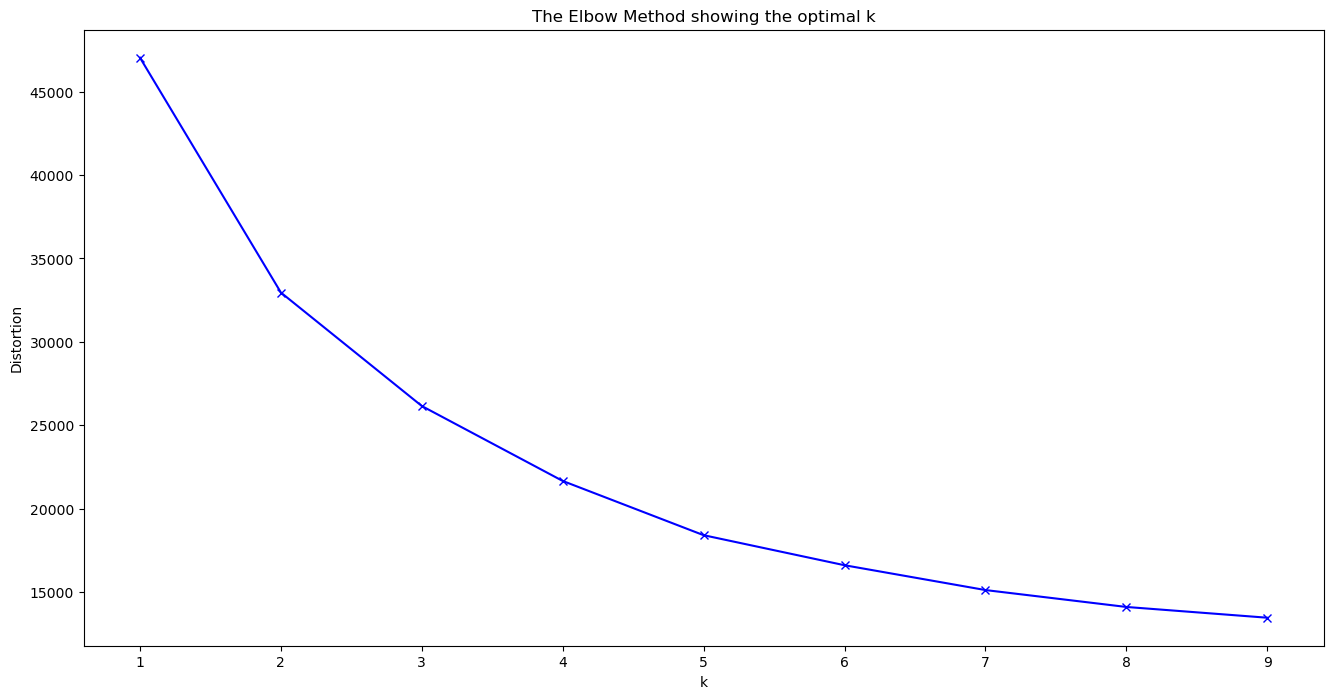

In [6]:
distortions = []
K = range(1,10)
for k in K:
    kmeans_model = KMeans(n_clusters=k)
    kmeans_model.fit(tracks_with_no_outliers)
    distortions.append(kmeans_model.inertia_)
    
#Generate plot 
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We could see that after the 4th x-point (cluster), the rate of decrease shifts. 

Thus, it can be considered the "elbow" or optimal number of clusters. 

Silhoutte coefficient method - Next, we will look at the silhoutte coefficient technique, which 
calculates silhoutte scores (measure of how well separated the clusters are and how well each data 
point is assigned to a cluster). 

Higher values on a scale of [-1, 1] indicate better clustering.

In [7]:
#silhouette_scores = []
#for k in range(2, 10):
        #kmeans_model = KMeans(n_clusters=k)
        #kmeans_model.fit(tracks_with_no_outliers)
        #labels = kmeans_model.labels_
        #score = silhouette_score(tracks_with_no_outliers, labels)
        #silhouette_scores.append(score)

# Plot the silhouette method graph
#plt.figure(figsize=(8, 6))
#plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
##plt.xlabel('Number of Clusters (K)')
#plt.ylabel('Silhouette Score')
#plt.title('Silhouette Method for Optimal K')
#plt.xticks(range(2, max_clusters + 1))
#plt.grid(True)
#plt.show()

Although there is slight subjectivety associated with the elbow method, we will be using it over the 
silhoutte method beceause of how computationlly expensive the silhouttee method is. 

In fact, we couldn't even plot the graph in a rational amount of time because of how large our data set was and 
how computationally expensive the silhouette coefficient method is. 

Exploring different clustering algorithims 

Two other clustering algorithims we considered are the KMedians and DBSCAN

1. KMedians - We considered that this clustering method may be superior to KMeans because it calculates the 
centroid of each cluster as the MEDIAN of the data points, rather than the MEAN. 

Thus, it is less sensitive to outliers in a data set, which in turns enables better performance. 

2. DBSCAN - This method can be considered superior to KMeans because it does not require specifying the # of 
clusters in advance, which makes the process of clustering significanlty more efficient (no need to use 
silhoiutte coeff) and less subjective (no need to analyze KMeans graph). 

More so, DBSCAN handles outliers as noise, which prevent the outlier issue present in KMeans. 

In [8]:
#Initialize the KMeans model with 4 clusters 
kmeans = KMeans(n_clusters=4)


In [9]:
#Train the model with our data 
kmeans.fit(tracks_with_no_outliers)

/Users/GaryMaimon/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4)

In [10]:
#Add a new column 'type' to the df. 
track_df_with_no_outliers["type"] = kmeans.labels_

/var/folders/0f/y6dh93s53bdbxmq2cy_lgjxh0000gp/T/ipykernel_35762/2433079239.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df_with_no_outliers["type"] = kmeans.labels_


In [11]:
# Save the dataframe with cluster information as a new CSV file
track_df_with_no_outliers.to_csv("result.csv", index=False)

# Load the updated data with cluster info
tracks = pd.read_csv("result.csv")
tracks.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,type
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,0
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,2
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,2
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,2
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,2


In [12]:
# Prompt the user to enter three favorite songs' ids
first_id = input('Enter ID of your first favorite song\n> ').strip()

Enter ID of your first favorite song
> 5SuOikwiRyPMVoIQDJUgSV


In [13]:
second_id = input('Enter ID of your second favorite song\n> ').strip()

Enter ID of your second favorite song
> 4qPNDBW1i3p13qLCt0Ki3A


In [14]:
third_id = input('Enter ID of your third favorite song\n> ').strip()

Enter ID of your third favorite song
> 1iJBSr7s7jYXzM8EGcbK5b


In [15]:
ids = [first_id, second_id, third_id]

In [16]:
# Filter the dataframe to get the user's favorite songs
favorites = tracks[tracks["track_id"].isin(ids)]

In [17]:
# Find out the most frequent cluster among the user's favorite songs
clusters = favorites['type'].value_counts()
user_favorite_cluster = clusters.idxmax()

print('\nFavorite cluster:', user_favorite_cluster, '\n')


Favorite cluster: 0 



In [18]:
# Get the songs that belong to the user's favorite cluster
suggestions = tracks[tracks['type'] == user_favorite_cluster]

User Feedback - We made it so that the user can further filter song suggestions by getting song suggestions that have a certain popularity 

In [19]:
popularity_level = int(input('Enter a popularity level that is on a range between 0 and 100\n> '))
optimized_suggestions = suggestions[tracks['popularity'] >= popularity_level]



Enter a popularity level that is on a range between 0 and 100
> 87


/var/folders/0f/y6dh93s53bdbxmq2cy_lgjxh0000gp/T/ipykernel_35762/1000132330.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  optimized_suggestions = suggestions[tracks['popularity'] >= popularity_level]


In [20]:
#TOP 5 user-optimized song-suggestions
for i in range(5):
    print(f"Track Name: {optimized_suggestions.iloc[i]['track_name']}")
    print(f"Album Name: {optimized_suggestions.iloc[i]['album_name']}")
    print(f"Track Artist: {optimized_suggestions.iloc[i]['artists']}")
    print()
    

Track Name: Daddy Issues
Album Name: Wiped Out!
Track Artist: The Neighbourhood

Track Name: Sweater Weather
Album Name: I Love You.
Track Artist: The Neighbourhood

Track Name: Daddy Issues
Album Name: Wiped Out!
Track Artist: The Neighbourhood

Track Name: Sweater Weather
Album Name: I Love You.
Track Artist: The Neighbourhood

Track Name: Miss You
Album Name: Miss You
Track Artist: Oliver Tree;Robin Schulz

